# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
#
# Add your code here
#
from google.colab import drive
import os,shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

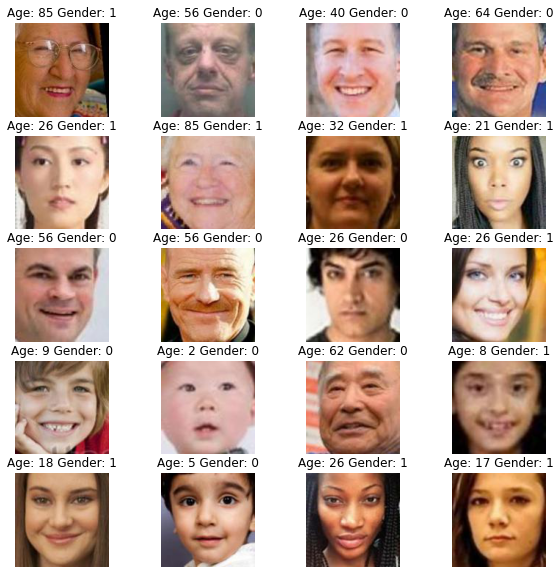

In [ ]:
#
# Add your code here
#
%matplotlib inline
entries = os.listdir('/content/drive/MyDrive/Colab Notebooks/train_val')

def display_img(nrow,ncol):

  #choose random images from the dataset
  display_entries=np.random.choice(entries,(nrow*ncol))

  # get the age and gender of the random images
  data_display=[]
  for e in display_entries:
    temp=e.split('_')
    data_display.append((temp[0],temp[1]))
  
  #create grid to display image
  fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10,10))
  img_index=0
  #display images as a grid
  for i in range(nrow):
    for j in range(ncol):
      if img_index<=nrow*ncol:
        # print(display_entries[i])
        # print("***")
        img = plt.imread('drive/My Drive/Colab Notebooks/train_val/'+display_entries[img_index])
        
        axes[i,j].imshow(img)
#         print(img.shape)
        axes[i,j].axis('off')
        axes[i,j].set_title('Age:'+' '+data_display[img_index][0]+' '+'Gender:'+" "+data_display[img_index][1])
        img_index+=1


display_img(5,4)

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
#
# Add your code here
#

import cv2
images = []
ages = []
genders = []
files=os.listdir('/content/drive/MyDrive/Colab Notebooks/train_val')
path='/content/drive/MyDrive/Colab Notebooks/train_val/'
for file in files:
  # print(path+file)
  image = cv2.imread(path+file)
  
  # image = cv2.resize(image,dsize=(128,128))
  # image = image.reshape((128,128,3))
  images.append(image)
  split_var = file.split('_')
  ages.append(split_var[0])
  genders.append(int(split_var[1]) )

print(len(images))
print(images[0].shape)
print(genders[0])


5000
(128, 128, 3)
0


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [ ]:
#
# Add your code here
#
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
size=len(images)
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,128,128,3),dtype = 'float32')
for i in range(size):
    target[i,0] = int(ages[i])
    target[i,1] = int(genders[i])   
    features[i] = images[i]
features = features / 255


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True,random_state=11)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3,shuffle  = True,random_state=11)
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
datagen.fit(x_train)



## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                          

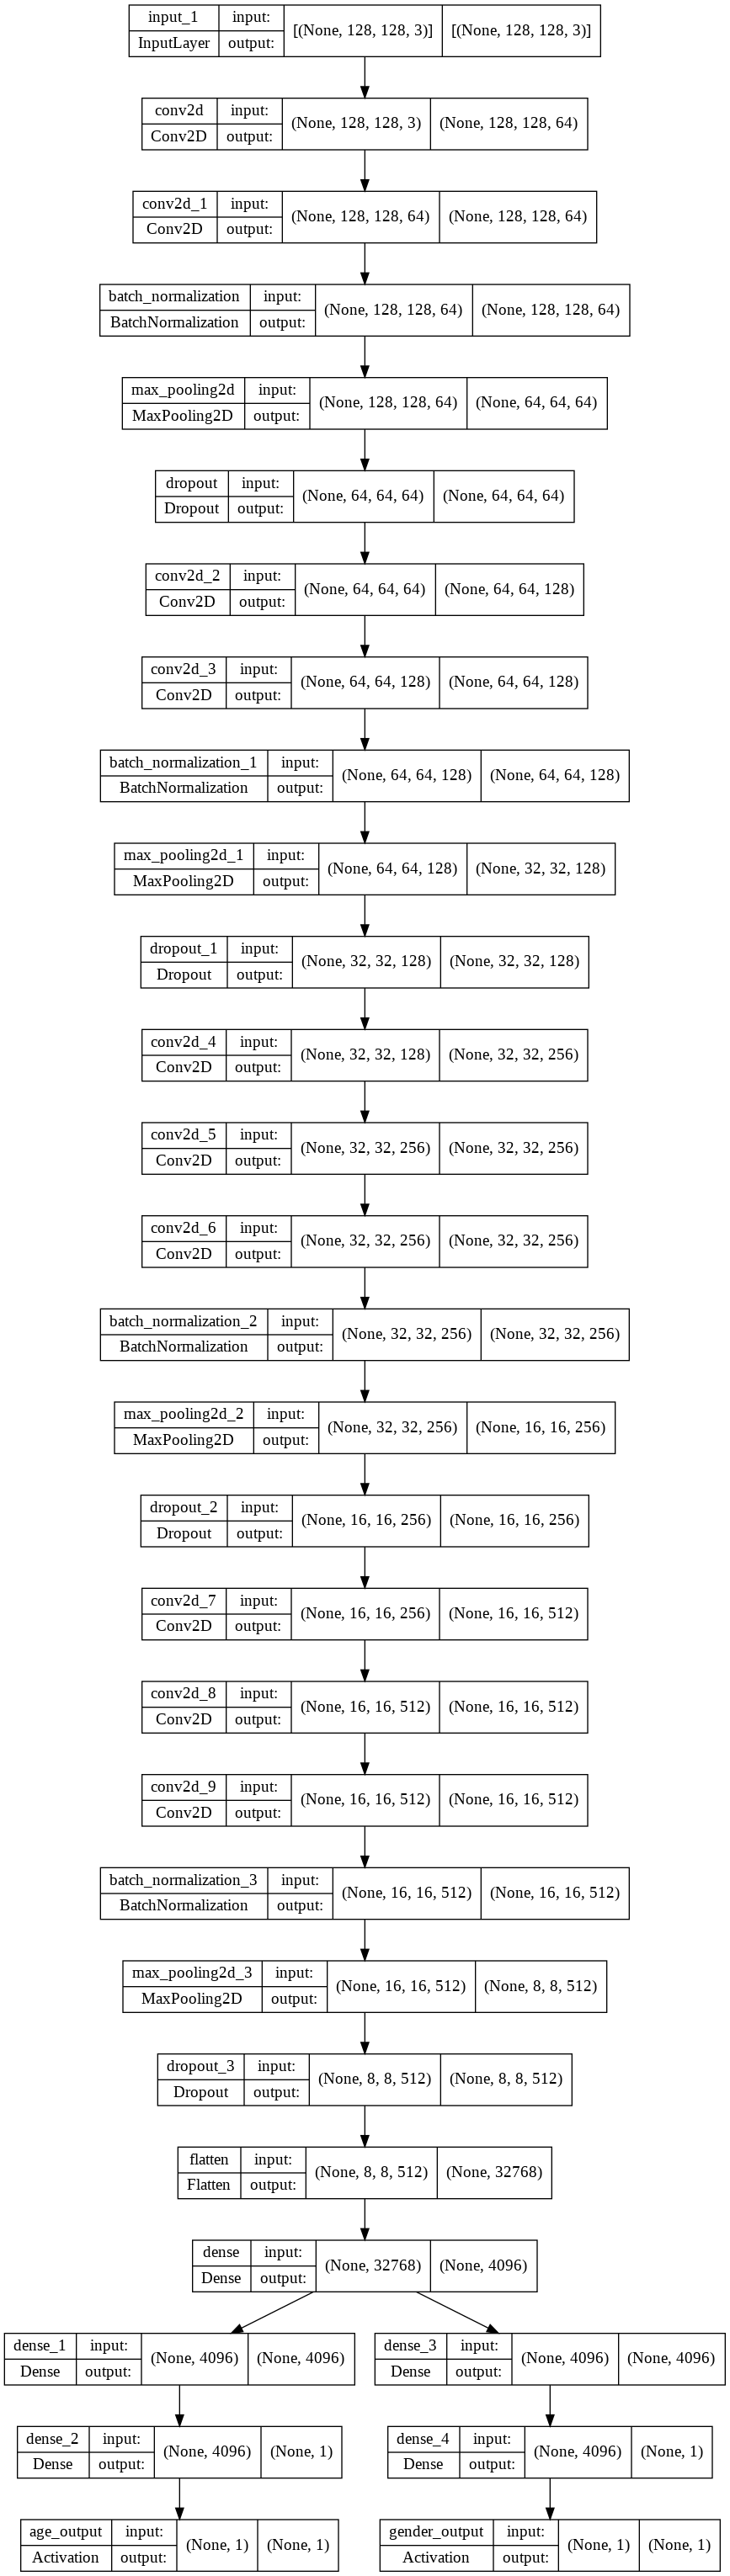

In [ ]:
#
# Add your code here
#
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os,shutil
from PIL import Image
from tensorflow.keras.utils import to_categorical
from keras.layers import Input
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation,BatchNormalization
from keras.models import Model 

def make_default_hidden_layers(inputs):

     
    x = Conv2D(64, (3, 3),activation='relu',padding="same")(inputs)
    x = Conv2D(64, (3, 3),activation='relu',padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3),activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3),activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    x = Conv2D(256, (3, 3),activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3),activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3),activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3),activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3),activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3),activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(4096,activation='relu')(x)
    return x

def build_gender_branch( inputs, num_genders=2):
    """
    Used to build the gender branch of our face recognition network.
    This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    followed by the Dense output layer.
    """
    # x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
    # x = self.make_default_hidden_layers(inputs)
    # x = BatchNormalization()(inputs)

    x = Dense(4096,activation='relu')(inputs)
    # x = Activation("relu")(x)
    # x = Dropout(0.5)(x)
    # x = Dense(num_genders)(x)
    x = Dense(1)(x)
    x = Activation("sigmoid", name="gender_output")(x)
      
    return x

def build_age_branch(inputs):   
    """
    Used to build the age branch of our face recognition network.
    This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    followed by the Dense output layer.
    """

    # x = self.make_default_hidden_layers(inputs)
    # x = Flatten()(inputs)
    # x = BatchNormalization()(inputs)
    
    x = Dense(4096,activation='relu')(inputs)
    # # x = Activation("relu")(x)
    
    # x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation("linear", name="age_output")(x)
    return x
def assemble_full_model( width, height):
    """
    Used to assemble our multi-output model CNN.
    """
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)
    common_branch=make_default_hidden_layers(inputs)
    age_branch = build_age_branch(common_branch)
    
    gender_branch = build_gender_branch(common_branch)
    model = Model(inputs=inputs,
                  outputs = [age_branch,gender_branch],
                  name="face_net")
    return model
modelA = assemble_full_model(128, 128)

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
#
# Add your code here
#
from tensorflow. keras.utils import plot_model

modelA.compile(optimizer='adam',
              loss={
                  'age_output': 'mse',
                  'gender_output': 'binary_crossentropy'},

              metrics={
                  'age_output': 'mae',
                  'gender_output': 'accuracy'})
h = modelA.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_val,[y_val[:,0],y_val[:,1]]),epochs = 50, batch_size=128,shuffle = True)

modelA.save('/content/drive/MyDrive/Colab Notebooks/'+"age_gender_A.h5")



Epoch 1/50
22/22 [==============================] - 69s 2s/step - loss: 95869.2891 - age_output_loss: 95837.0156 - gender_output_loss: 32.2643 - age_output_mae: 85.9602 - gender_output_accuracy: 0.4707 - val_loss: 953.4606 - val_age_output_loss: 836.0513 - val_gender_output_loss: 117.4094 - val_age_output_mae: 22.2085 - val_gender_output_accuracy: 0.4792
Epoch 2/50
22/22 [==============================] - 28s 1s/step - loss: 576.0118 - age_output_loss: 574.3867 - gender_output_loss: 1.6252 - age_output_mae: 18.3730 - gender_output_accuracy: 0.5354 - val_loss: 544.7090 - val_age_output_loss: 543.9113 - val_gender_output_loss: 0.7978 - val_age_output_mae: 17.3043 - val_gender_output_accuracy: 0.4800
Epoch 3/50
22/22 [==============================] - 28s 1s/step - loss: 456.9448 - age_output_loss: 456.1636 - gender_output_loss: 0.7812 - age_output_mae: 16.3942 - gender_output_accuracy: 0.5500 - val_loss: 407.3282 - val_age_output_loss: 406.6366 - val_gender_output_loss: 0.6916 - val_age_

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


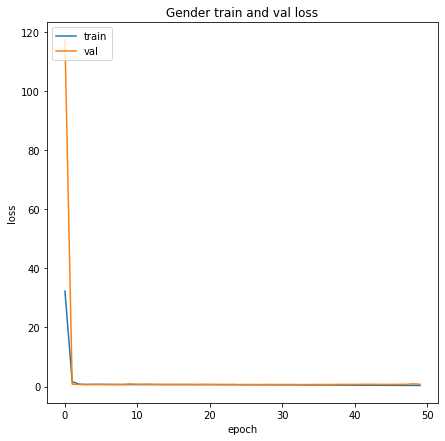

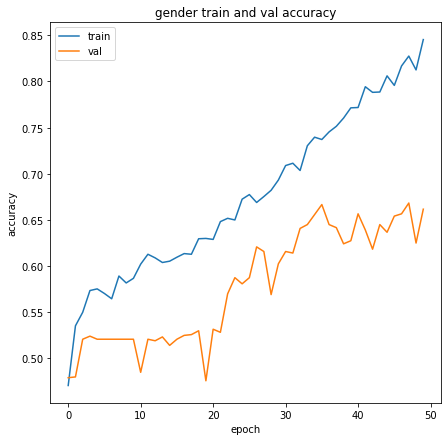

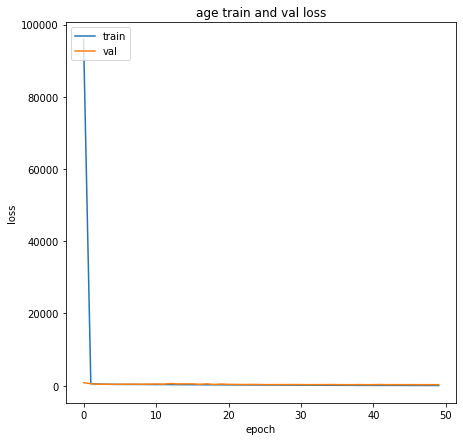

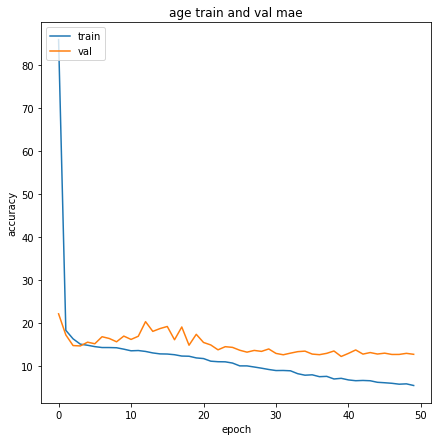

In [ ]:
#
# Add your code here
%matplotlib inline
history = h
# fig, axes = plt.subplots(nrows=4, figsize=(10,10))
plt.figure(figsize=(7,7))
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender train and val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender train and val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age train and val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.title('age train and val mae')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_batch_size = 128
# test_generator = data_generator.generate_images(test_x, is_training=False, batch_size=test_batch_size)
age_pred,gender_pred = modelA.predict(x_test,steps=len(x_test)//test_batch_size)
# print(age_pred)
# print(gender_pred)
t = modelA.evaluate(x=x_test,y=[y_test[:,0],y_test[:,1]],steps=len(x_test)//test_batch_size)
# print(t)


## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 4, 4, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 1, 1, 512)   0           ['vgg16[0][0]']                  
                                                                                                  
 dense_5 (Dense)             

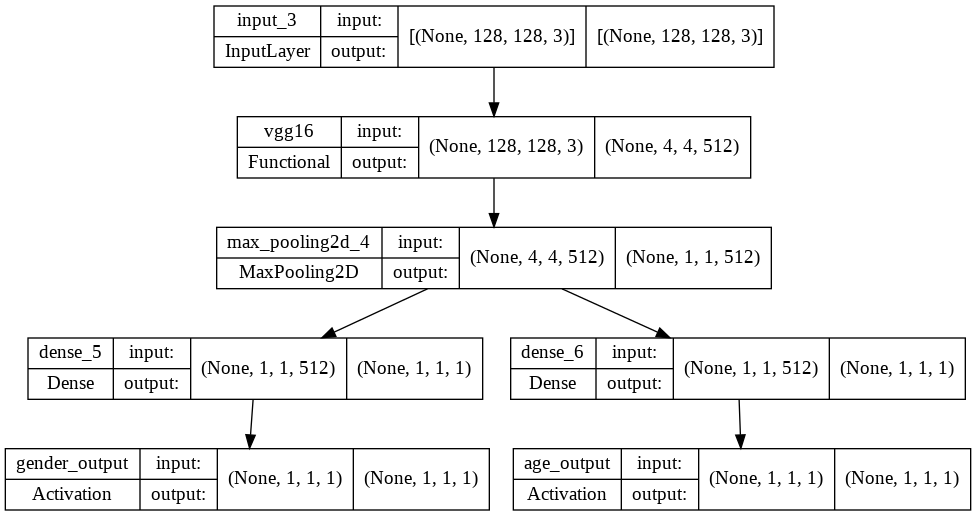

In [ ]:
#
# Add your code here
#
from keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (128, 128, 3),include_top = False, weights = 'imagenet')
# base_model.trainable=False
inputs=Input(shape=(128,128,3))
x=base_model(inputs=inputs,training=False)
x=MaxPooling2D(pool_size=(3, 3))(x)
#gender branch
gender_branch=Dense(1)(x)
gender_branch = Activation("sigmoid", name="gender_output")(gender_branch)

#age branch
age_branch=Dense(1)(x)
age_branch=Activation("linear", name="age_output")(age_branch)

modelB = Model(inputs=inputs, outputs=[gender_branch,age_branch])


modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
#
# Add your code here
#

modelB.save(your_model_folder+"age_gender_B.h5")

NameError: ignored

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#